# Project Assignment - Introduction to Computer Vision and Image Processing (Coursera)

This Jupyter notebook contains the solution for the project assignment given in the Introduction to Computer Vision and Image Processing (Coursera) course.

It was done following the goals given in the Audit version of the course.

## Import libraries

In [209]:
import numpy as np
import cv2
import os
import pathlib
import matplotlib.pyplot as plt
import torch
import torchvision
import PIL
from tqdm import tqdm
import sklearn.model_selection
import urllib.request
import zipfile
import warnings
warnings.filterwarnings("ignore")

## Classes

In [210]:
class StopRecogniserNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.resnet_model.eval()

        # Freeze all the parameters in the model
        for param in self.resnet_model.parameters():
            param.requires_grad = False

        num_ftrs = self.resnet_model.fc.out_features
        self.linear = torch.nn.Linear(num_ftrs, 128)
        self.classifier = torch.nn.Linear(128,1)
        self.dropout = torch.nn.Dropout(p=0.25)
    
    def forward(self,data):
        x = self.resnet_model(data)
        x = self.dropout(x)
        x = self.linear(x)
        x = torch.nn.functional.relu(x)
        x = self.classifier(x)
        x = torch.nn.functional.sigmoid(x)
        return x

class StopRecogniserDataset(torch.utils.data.Dataset):
    def __init__(self, filepaths, labels, transform = None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        im = PIL.Image.open(self.filepaths[idx])
        im = im.convert("RGB")
        label = self.labels[idx]
        label = torch.tensor(label, dtype = torch.float32)
        
        if self.transform:
            im = self.transform(im)
        
        return im, label

## Functions

In [211]:
def listdir_fullpath(folderpath):
    return [f"{folderpath}\\{x}" for x in os.listdir(folderpath)]

def get_only_images_filepaths(filepaths):
    images_filepaths = []
    for filepath in filepaths:
        file_extension = pathlib.Path(filepath).suffix
        file_extension = file_extension.lower()

        if file_extension in [".png", ".jpg", ".jpeg"]:
            images_filepaths.append(filepath)
    
    return images_filepaths

def train_model(model, train_dl, val_dl, loss_function, optimiser, total_epochs, device):
    train_epochs_losses, train_epochs_accuracies = [], []
    val_epochs_losses, val_epochs_accuracies = [], []
    best_val_loss = 999
    best_model_dict = None

    for epoch in range(total_epochs):
        train_epoch_i_losses, train_epoch_i_accuracies = [], []
        val_epoch_i_losses, val_epoch_i_accuracies = [], []

        # Training
        for _, batch in enumerate(train_dl):
            model.train() # Set layers into training mode
            model.resnet_model.eval() # Pretrained model layers must behave as in evaluation mode. Otherwise Batch Normalisation and Dropout statistics change

            images, labels = batch
            images, labels = images.to(device), labels.to(device) 

            # Forward pass
            predictions = model(images)
            predictions = predictions.squeeze()

            # Backward pass
            loss = loss_function(predictions, labels)
            loss.backward()

            # Optimise the weights and reset the gradients
            optimiser.step()
            optimiser.zero_grad()

            # Calculate the accuracy of the batch
            acc = (predictions.round() == labels).float().mean().item()

            train_epoch_i_losses.append(loss.item())
            train_epoch_i_accuracies.append(acc)
        
        # Validation
        for _, batch in enumerate(val_dl):
            model.eval() # Set layers into evaluation mode

            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            predictions = model(images)
            predictions = predictions.squeeze()

            # Compute validation loss and accuracy 
            loss = loss_function(predictions, labels)
            acc = (predictions.round() == labels).float().mean().item()

            val_epoch_i_losses.append(loss.item())
            val_epoch_i_accuracies.append(acc)

        train_epoch_i_loss = np.mean(train_epoch_i_losses)
        train_epoch_i_acc = np.mean(train_epoch_i_accuracies)
        val_epoch_i_loss = np.mean(val_epoch_i_losses)
        val_epoch_i_acc = np.mean(val_epoch_i_accuracies)

        print(f"Epoch {epoch + 1}/{total_epochs} - Loss: {train_epoch_i_loss}, Accuracy: {train_epoch_i_acc}, Val Loss: {val_epoch_i_loss}, Val Accuracy: {val_epoch_i_acc}")
        
        train_epochs_losses.append(train_epoch_i_loss)
        train_epochs_accuracies.append(train_epoch_i_acc)
        val_epochs_losses.append(val_epoch_i_loss)
        val_epochs_accuracies.append(val_epoch_i_acc)

        if best_val_loss > val_epoch_i_loss:
            best_val_loss = val_epoch_i_loss
            best_model_dict = model.state_dict()
            print("New best model!")
    
    model.load_state_dict(best_model_dict)

    return model, {"train_loss": train_epochs_losses, "train_acc": train_epochs_accuracies, "val_loss": val_epochs_losses, "val_acc": val_epochs_accuracies}

## Download data and unzip files

In [212]:
# Download datasets
urllib.request.urlretrieve("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/dataset/stop.zip", 'stop.zip')
urllib.request.urlretrieve("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/dataset/not_stop.zip", 'non_stop.zip')

# Unzip files
current_directory = os.getcwd()
with zipfile.ZipFile("stop.zip", 'r') as zip_ref:
    zip_ref.extractall(current_directory)

with zipfile.ZipFile("non_stop.zip", 'r') as zip_ref:
    zip_ref.extractall(current_directory)

## Get data filepaths

In [213]:
# Get Not-STOP and STOP folderpaths
current_path = os.getcwd()
stop_signs_folderpath = f"{current_path}\\stop"
not_stop_signs_folderpath = f"{current_path}\\not_stop"

# Get all filepaths containing STOP images
all_stop_filepaths = listdir_fullpath(stop_signs_folderpath)
all_stop_filepaths = get_only_images_filepaths(all_stop_filepaths)

# Get all filepaths containing Not-STOP images
all_not_stop_filepaths = listdir_fullpath(not_stop_signs_folderpath)
all_not_stop_filepaths = get_only_images_filepaths(all_not_stop_filepaths)

# Concatenate STOP and Not-STOP images and attribute a label to each of them (0: Not-STOP; 1: STOP)
all_filepaths = all_stop_filepaths + all_not_stop_filepaths
all_labels = np.hstack((np.ones(len(all_stop_filepaths),), np.zeros(len(all_not_stop_filepaths),)))

## Prepare datasets loaders

In [214]:
# Preprocessing steps performed on the images
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Divide dataset into train, validation, and test sets
train_filepaths, test_filepaths, train_labels, test_labels = sklearn.model_selection.train_test_split(all_filepaths, all_labels, test_size = 0.2, shuffle = True)
train_filepaths, val_filepaths, train_labels, val_labels = sklearn.model_selection.train_test_split(train_filepaths, train_labels, test_size = 0.25, shuffle = True)

# Build dataset
train_dataset = StopRecogniserDataset(train_filepaths, train_labels, preprocess)
val_dataset = StopRecogniserDataset(val_filepaths, val_labels, preprocess)
test_dataset = StopRecogniserDataset(test_filepaths, test_labels, preprocess)

# Build data loader
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

## Train Deep Neural Network

Using cache found in C:\Users\dafa/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 1/20 - Loss: 0.6248055770993233, Accuracy: 0.6390625014901161, Val Loss: 0.46157480478286744, Val Accuracy: 0.925
New best model!
Epoch 2/20 - Loss: 0.4936547875404358, Accuracy: 0.8109375014901161, Val Loss: 0.45311559438705445, Val Accuracy: 0.875
New best model!
Epoch 3/20 - Loss: 0.3844491057097912, Accuracy: 0.8812500014901161, Val Loss: 0.30791768729686736, Val Accuracy: 0.925
New best model!
Epoch 4/20 - Loss: 0.35461683943867683, Accuracy: 0.8968750014901161, Val Loss: 0.2814101129770279, Val Accuracy: 0.925
New best model!
Epoch 5/20 - Loss: 0.2725122142583132, Accuracy: 0.9296875, Val Loss: 0.22744240760803222, Val Accuracy: 0.95
New best model!
Epoch 6/20 - Loss: 0.2593388054519892, Accuracy: 0.9140625, Val Loss: 0.28031596541404724, Val Accuracy: 0.925
Epoch 7/20 - Loss: 0.21202801261097193, Accuracy: 0.9609375, Val Loss: 0.2392282545566559, Val Accuracy: 0.925
Epoch 8/20 - Loss: 0.20503516867756844, Accuracy: 0.953125, Val Loss: 0.20425582230091094, Val Accuracy: 0.9

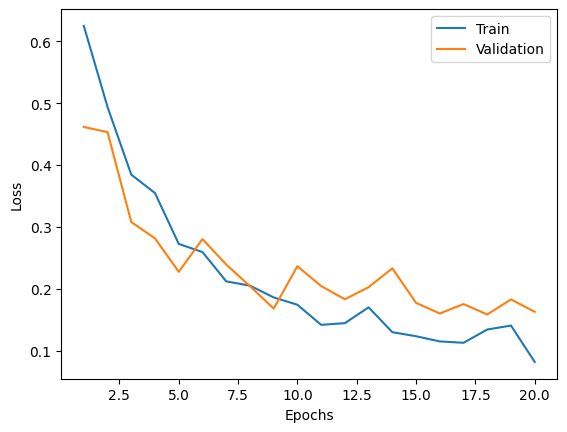

In [217]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialise the model and send it to the training device
model = StopRecogniserNet()
model = model.to(device)
loss_function = torch.nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-4)
EPOCHS = 20

# Optimise the weights and get the best model considering the validation set
model, training_metrics = train_model(model, train_dl, val_dl, loss_function, optimiser, EPOCHS, device)

plt.figure()
plt.plot(np.arange(1,EPOCHS + 1), training_metrics["train_loss"])
plt.plot(np.arange(1,EPOCHS + 1), training_metrics["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

## Test model

In [226]:
true_predictions = 0
num_samples = 0
for idx, batch in enumerate(test_dl):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    test_predictions = model(images)

    true_predictions += (test_predictions.T.round() == labels).float()[0].sum().item()
    num_samples += len(labels)

print(f"Test accuracy: {true_predictions/num_samples}")

Test accuracy: 0.95
